In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import tensorflow as tf

import gpflow
from gpflow.utilities import read_values, multiple_assign, set_trainable
from gpflow.inducing_variables import InducingPoints
import gpmaniflow
from gpmaniflow.models.SVGP import SVGP

import gpmaniflow.samplers
from gpmaniflow.samplers import initialize_sampler
from gpmaniflow.curves import BezierCurve

In [2]:
pX = np.reshape(np.random.uniform(-2, 2, 200*2), [200, 2])
X = np.random.uniform(-3, 3, 200*2)[:, None]
X = np.reshape(X, [200, 2])
Y = 2 * X[:,0] ** 2 + 1 * X[:,1] + np.random.randn(200) * 0.1
Y = np.reshape(Y, [200,1])
Z = np.random.uniform(-3, 3, 60*2)[:, None]
Z = np.reshape(Z, [60, 2])

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

In [3]:
end_points = np.array([[[0,0]],[[1,1]]])
end_points.shape

c = BezierCurve(end_points)
t = np.linspace(0,1, 50)
print(t)
C = c(t)
print(C)
C.shape

[0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]
tf.Tensor(
[[0.         0.        ]
 [0.02040816 0.02040816]
 [0.04081633 0.04081633]
 [0.06122449 0.06122449]
 [0.08163265 0.08163265]
 [0.10204082 0.10204082]
 [0.12244898 0.12244898]
 [0.14285714 0.14285714]
 [0.16326531 0.16326531]
 [0.18367347 0.18367347]
 [0.20408163 0.20408163]
 [0.2244898  0.2244898 ]
 [0.24489796 0.24489796]
 [0.26530612 0.26530612]
 [0.28571429 0.28571429]
 [0.30612245 0.30612245]
 [0.32653061 0.32653061]
 [0.3

TensorShape([50, 2])

In [4]:
kernel = gpflow.kernels.SquaredExponential()

model = SVGP(kernel, likelihood = gpflow.likelihoods.Gaussian(), inducing_variable=InducingPoints(Z.copy()))

train_iter = iter(train_dataset.repeat())
training_loss = model.training_loss_closure(train_iter, compile=True)
optimizer = tf.keras.optimizers.Adam(0.01)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
elbo_hist = []
for step in range(4000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

ELBO = model.elbo((X,Y))

Step: 0, Mini batch elbo: -7504.697219697572
Step: 50, Mini batch elbo: -4485.650101199825
Step: 100, Mini batch elbo: -2616.948246722109
Step: 150, Mini batch elbo: -1552.9233282033517
Step: 200, Mini batch elbo: -1029.6195629978347
Step: 250, Mini batch elbo: -775.273302938316
Step: 300, Mini batch elbo: -656.7234746668564
Step: 350, Mini batch elbo: -593.1527721886926
Step: 400, Mini batch elbo: -546.5803669787952
Step: 450, Mini batch elbo: -516.6831236300876
Step: 500, Mini batch elbo: -496.33343283013664
Step: 550, Mini batch elbo: -482.40393011168396
Step: 600, Mini batch elbo: -471.9588333829903
Step: 650, Mini batch elbo: -463.8970203975657
Step: 700, Mini batch elbo: -457.17143944208175
Step: 750, Mini batch elbo: -451.55561653458636
Step: 800, Mini batch elbo: -446.67338675537434
Step: 850, Mini batch elbo: -442.532547072972
Step: 900, Mini batch elbo: -438.2624034279709
Step: 950, Mini batch elbo: -435.38004368136075
Step: 1000, Mini batch elbo: -431.1021418926653
Step: 105

In [9]:
model.MatheronSampler = initialize_sampler(from_df = True)

I'm here


In [10]:
J = model.MatheronSampler(C)
J.shape

TensorShape([1, 50, 2, 1])

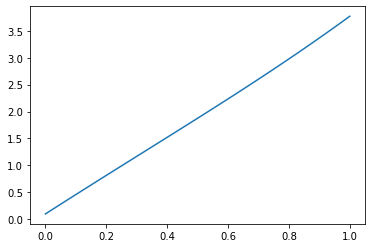

In [11]:
#J = tf.reshape(J, [1, 1, 50, 2])
plt.plot(t, J[0,:,0,0])

In [8]:
plt.plot(t, J[0,:,1])

InvalidArgumentError: slice index 1 of dimension 2 out of bounds. [Op:StridedSlice] name: strided_slice/